# **Deep Generative Models: Variational Autoencoders and Generative Adversarial Networks**



## Summary



**Autoencoders**: Autoencoders are usefull to create "compressed" representations of samples (e.g. images). In particular, they are composed of two blocks: (1) The encoder and (2) The decorder. The encoder is implemented as a network computing a vector $\mathbf{z} \in R^D$ from a sample $\mathbf{x}$. If $\mathbf{x} \in R^{W\times H \times 3}$ is an image, the network is tipically a CNN composed of convolutional blocks and pooling layers. On the other hand, the decoder computes the approximate inverse of the encoder, by taking as input the vector $\mathbf{z}$ and using a CNN with upsampling layers to compute a reconstructed image $\mathbf{x}_{\text{rec}}$.

The decoder/encoder parameters are tipically optimized by minimizing the reconstruction loss (mean-squared errror) between the original sample $\mathbf{x}$ and the reconstructed one $\mathbf{x}_{\text{rec}}$.
<figure>
<center>
<img src='https://miro.medium.com/max/1400/1*bY_ShNK6lBCQ3D9LYIfwJg@2x.png' width="500" height="300"/>
<figcaption>Vanilla Autoencoder Illustration</figcaption></center>
</figure>

**Variational Autoencoders**: In many situations, we are not only interested in compress the samples $\mathbf{x}$ but we also want to be able to generate sythetic samples from the distrbution $p(\mathbf{x})$. Variational Autoencoders are a probabilistic model extending the vanilla AEs for this purpose.

The main idea in VAEs is to impose a prior distribution $p(\mathbf{z})$ (tipically a isotropic gaussian $N(0,I)$) so that we can then sample from $p(\mathbf{z})$ and use the decoder to generate synthetic samples. Given a sample $\mathbf{x}$, the encoder of a VAE outputs two set of variables: (i) The mean $\mu_x$ of the distribution $p(\mathbf{z}|\mathbf{x})$ and the logarithm of its variance $\sigma^2_x$.

During training, the encoder is used to obtain these variables for each $\mathbf{x}$ and sample a variable $\mathbf{z}$ from a gaussian distriubtion defined by $N(\mu_x,\sigma)$. The sampled $\mathbf{z}$ is used as input for the decoder to obtain a reconstructed image $\mathbf{x}_{rec}$. To generate the sample $z \sim N(\mu_x,\sigma)$, we can simply compute:

$\mathbf{z} = \mu_x + \epsilon * \sigma, \hspace{3mm} \text{where} \hspace{3mm} \epsilon \sim N(0,I)$.


In order to impose that the distribution $p(\mathbf{z}|\mathbf{x})$ is similar to the prior $p(\mathbf{z}) \sim N(0,I)$, a regularization is imposed over $\mu_x$ and  $\sigma^2_x$. In particular, the Kullback Leibler between $p(\mathbf{z}|\mathbf{x})$ and $p(\mathbf{z})$ is minimized during optimization as:

$KL(p(\mathbf{z}|\mathbf{x}) | p(\mathbf{z})) = 0.5*[\sum_i \mu^2_i + \sigma^2_i - \log(\sigma_i) -1] $

This ensures that we will generate realistic images if we sample vectors $\mathbf{z}$ from the prior $p(\mathbf{z}) \sim N(0,I)$ and then use these samples to generate images using the decoder.

<figure>
<center>
<img src='https://miro.medium.com/max/1400/1*Q5dogodt3wzKKktE0v3dMQ@2x.png' width="500" height="300"/>
<figcaption>Variational Autoencoder Illustration</figcaption></center>
</figure>

**Generative Adversarial Networks**: GANs are deep generative models which use a different strategy than VAEs for training. Similar to VAEs, GANs also have a generator which receives a random vector $\mathbf{z} \sim N(0,I)$ to generate a synthectic image $\mathbf{x}_{gen}$. However, instead of using an encoder , GANs are trained employing a binary classifier implemented with a neural network. This binary classifier is known as the discriminator and it tries to distinguish between real samples $\mathbf{x}$ and generated ones $\mathbf{x}_{gen}$.
<figure>
<center>
<img src='https://www.researchgate.net/profile/Emiliano_De_Cristofaro/publication/317061929/figure/fig1/AS:497029693362176@1495512521469/Generative-Adversarial-Network-GAN.png' width="400" height="200"/>
<figcaption>Image Caption</figcaption></center>
</figure>

The generator and the discriminator are trained by playing a "game" where they compete between each other. The generator try to "fool" the discriminator generating realistic samples, whereas the discriminator attempts to detect what images are real or generated. In particular, the networks maximize the following losses:

$L_{Disc} = \sum_{\mathbf{x}_{gen} \sim Gen(\mathbf{z})} \log(1-Disc(\mathbf{x}_{gen})) + \sum_{\mathbf{x}_{real}} Disc(\mathbf{x}_{real})$

$L_{Gen} = \sum_{\mathbf{x}_{gen} \sim Gen(\mathbf{z})} \log(Disc(\mathbf{x}_{gen}))$

## Example of Variational Autoencoder on MNIST

In the following, we will implement, train and evaluate a VAE on the MNIST dataset wit 32x32 images.




### Encoder/Decoder definitions

Let's define the encoder and decoder networks:

(1) The encoder is composed of different blocks composed of a convolution + batch normalization + ReLU layers. Additionally, average pooling is used to reduce the spatial resolution at the end of each block. After these blocks, a fully-connected layer is used to compute two vectors representing the mean $\mu_x$ and the logarithm of the variance $\sigma^2$ of the variable $\mathbf{z}$ for a given sample $\mathbf{x}$

(2) The decoder is used to transform a vector $\mathbf{z}$ to an image $\mathbf{x}$. It is composed of an initial fully connected layer and a set of batch normalization +  ReLU + convolution blocks. Nearest neighbour upsampling is used to  progressevely increase the spatial resolution of the tensors. A final sigmoid function is used to normalize the output pixels values between 0 and 1.

In [ ]:
import torch
import torch.nn as nn

# Convolution + BatchNormnalization + ReLU block for the encoder
class ConvBNReLU(nn.Module):
  def __init__(self,in_channels, out_channels, pooling=False):
    super(ConvBNReLU, self).__init__()
    self.conv = nn.Conv2d(in_channels,out_channels,kernel_size=3,
                          padding = 1)
    self.bn = nn.BatchNorm2d(out_channels)
    self.relu = nn.ReLU(inplace=True)

    self.pool = None
    if(pooling):
      self.pool = nn.AvgPool2d(2,2)

  def forward(self,x):
    if(self.pool):
      out = self.pool(x)
    else:
      out = x
    out = self.relu(self.bn(self.conv(out)))
    return out

#  BatchNormalization + ReLU block + Convolution for the decoder
class BNReLUConv(nn.Module):
  def __init__(self,in_channels, out_channels, pooling=False):
    super(BNReLUConv, self).__init__()
    self.bn = nn.BatchNorm2d(in_channels)
    self.relu = nn.ReLU(inplace=True)
    self.conv = nn.Conv2d(in_channels,out_channels,kernel_size=3,
                          padding = 1)

    self.pool = None
    if(pooling):
      self.pool = nn.UpsamplingNearest2d(scale_factor=2)

  def forward(self,x):
    out = self.relu(self.bn(x))
    if(self.pool):
      out = self.pool(out)
    out = self.conv(out)
    return out

# Encoder definition with 3 COnv-BN-ReLU blocks and fully-connected layer
class Encoder(nn.Module):
  def __init__(self,out_features,base_channels=16):
    super(Encoder, self).__init__()
    self.layer1 = ConvBNReLU(1,base_channels,pooling=False)
    self.layer2 = ConvBNReLU(base_channels,base_channels*2,pooling=True)
    self.layer3 = ConvBNReLU(base_channels*2,base_channels*4,pooling=True)
    self.fc = nn.Linear(8*8*base_channels*4,out_features)

  def forward(self,x):
    out = self.layer1(x)
    out = self.layer2(out)
    out = self.layer3(out)
    return self.fc(out.view(x.shape[0],-1))

# Decoder definition with a fully-connected layer and 3 BN-ReLU-COnv blocks and
class Decoder(nn.Module):
  def __init__(self,out_features,base_channels=16):
    super(Decoder, self).__init__()
    self.base_channels = base_channels
    self.fc = nn.Linear(out_features,8*8*base_channels*4)
    self.layer3 = BNReLUConv(base_channels*4,base_channels*2,pooling=True)
    self.layer2 = BNReLUConv(base_channels*2,base_channels,pooling=True)
    self.layer1 = BNReLUConv(base_channels,1,pooling=False)

  def forward(self,x):
    out = self.fc(x)
    out = out.view(x.shape[0],self.base_channels*4,8,8)
    out = self.layer3(out)
    out = self.layer2(out)
    out = self.layer1(out)
    return torch.sigmoid(out)

### Autoencoder Definition

We use the Encoder and Decoder modules to create a VAE class.

In [ ]:
class VAE(nn.Module):
  def __init__(self, out_features=32,base_channels=16):
    super(VAE, self).__init__()
    # Initialize the encoder and decoder using a dimensionality out_features for the vector z
    self.out_features = out_features
    self.encoder = Encoder(out_features*2,base_channels)
    self.decoder = Decoder(out_features,base_channels)

  # function to obtain the mu and sigma of z for a samples x
  def encode(self,x):
    aux = self.encoder(x)
    # get z mean
    z_mean = aux[:,0:self.out_features]
    # get z variance
    z_log_var = aux[:,self.out_features::]
    return z_mean, z_log_var

  # function to generate a random sample z given mu and sigma
  def sample_z(self,z_mean,z_log_var):
    z_std = z_log_var.mul(0.5).exp()
    samples_unit_normal = torch.randn_like(z_mean)
    samples_z = samples_unit_normal*z_std + z_mean
    return samples_z

  # (1) encode a sample
  # (2) obtain a random vector z from mu and sigma
  # (3) Reconstruct the image using the decoder
  def forward(self,x):
    z_mean, z_log_var = self.encode(x)
    samples_z = self.sample_z(z_mean,z_log_var)
    x_rec = self.decoder(samples_z)
    return x_rec, z_mean, z_log_var

# Print summary of the mode
print('MNIST VAE Definition')
vae = VAE(32)
print(vae)

### MNIST Dataset Loaders

Simple MNIST data loader definition

In [ ]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as tf
import matplotlib.pyplot as plt
import PIL
from google.colab import drive


# Load an image
drive.mount('/content/drive')
data_path = '/content/drive/My Drive/DeepLearning_2024/P4/Data/'
results_path = '/content/drive/My Drive/DeepLearning_2024/P4/Results/'

#Making native class loader
class MNIST(torch.utils.data.Dataset):
    # Initialization method for the dataset
    def __init__(self,dataDir = data_path+'/mnist/train.pt',transform = None):
        self.data, self.labels = torch.load(dataDir)
        self.transform = transform
     # What to do to load a single item in the dataset ( read image and label)
    def __getitem__(self, index):
        data = self.data[index]
        lbl = self.labels[index]

        data = PIL.Image.fromarray(data.numpy(), mode='L')
        # Apply a trasnformaiton to the image if it is indicated in the initalizer
        if self.transform is not None :
            data = self.transform(data)

        # return the image and the label
        return data,lbl

        pass

    # Return the number of images
    def __len__(self):
        return len(self.data)

tr = tf.Compose([
        tf.Resize((32,32)),
        tf.ToTensor(), # convert image to pytorch tensor [0..,1]
        ])


# Initialize the dataset
MNISTTrain = MNIST(data_path+'/mnist/train.pt',tr)

# Class to iterate over the dataset (DataLoader)
train_loader = torch.utils.data.DataLoader(dataset=MNISTTrain, # indicate the used dataset
                                           batch_size=128, # Number of images that will be loaded for iteration
                                           shuffle=True) # Sequential or random data loading
MNISTTest = MNIST(data_path+'/mnist/test.pt',tr)
test_loader = torch.utils.data.DataLoader(dataset=MNISTTest,
                                          batch_size=64,
                                          shuffle=False)

### Train functions VAE

In [ ]:
## Kullback-Leibler regularization computation
def kl_divergence(z_mean,z_log_var):
  kl_loss = 0.5 * torch.sum((torch.exp(z_log_var) + z_mean**2 - 1.0 - z_log_var), axis=1)
  return kl_loss.mean()

# Train function
def train_VAE(vae,  train_loader, optimizer, kl_weight=0.001, num_epochs=10, model_name='vae_mnist.ckpt', device='cpu'):
    vae.to(device)
    vae.train() # Set the model in train mode
    total_step = len(train_loader)
    losses_list = []
    criterion = nn.MSELoss() # Use mean-squared error to compare the original and reconstructe images

    # Iterate over epochs
    for epoch in range(num_epochs):
        # Iterate the dataset
        rec_loss_avg = 0
        kl_loss_avg = 0
        nBatches = 0
        for i, (images, labels) in enumerate(train_loader):
            # Get batch of samples and labels
            images = images.to(device)

            # Forward pass (get encoder variables and reconstructed images)
            x_rec, z_mean, z_log_var = vae(images)

            reconstruction_loss = criterion(x_rec, images) # Reconstruction loss (x,x_rec)
            kl_loss = kl_divergence(z_mean, z_log_var) # Compute KL divergecnes KL( N(mu_x,sigma_x) || N(0,I))

            # Backward and optimize reconstruction loss and kl regularization
            optimizer.zero_grad()
            loss = reconstruction_loss + kl_loss*kl_weight # we use a weight to balance the importance of the KL loss
            loss.backward()
            optimizer.step()

            rec_loss_avg += reconstruction_loss.cpu().item()
            kl_loss_avg += kl_loss.cpu().item()

            nBatches+=1
            if (i+1) % 100 == 0:
                print ('Epoch [{}/{}], Step [{}/{}], Rec. Loss: {:.4f}, KL Loss: {:.4f}'
                       .format(epoch+1, num_epochs, i+1, total_step, rec_loss_avg / nBatches, kl_loss_avg / nBatches))
        print ('Epoch [{}/{}], Step [{}/{}], Rec. Loss: {:.4f}, KL Loss: {:.4f}'
                       .format(epoch+1, num_epochs, i+1, total_step, rec_loss_avg / nBatches, kl_loss_avg / nBatches))
        losses_list.append(rec_loss_avg / nBatches)
        # save trained model
        torch.save(vae.state_dict(), results_path+ '/' + model_name)

    return losses_list

### Train VAE

In [ ]:
# Training a VAE on MNIST: z has 32 dimensions
# We use Adam optimizer which is tipically used in VAEs and GANs

vae = VAE(32)
kl_weight=0.1

#Initialize optimizer
learning_rate = 0.001
optimizer = torch.optim.Adam(vae.parameters(),lr = learning_rate, weight_decay=1e-5)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

loss_list = train_VAE(vae, train_loader, optimizer, kl_weight=kl_weight,
                      num_epochs=20, model_name='vae_mnist.ckpt', device=device)

Epoch [1/20], Step [100/469], Rec. Loss: 0.0735, KL Loss: 1.5730
Epoch [1/20], Step [200/469], Rec. Loss: 0.0656, KL Loss: 0.8108
Epoch [1/20], Step [300/469], Rec. Loss: 0.0628, KL Loss: 0.5502
Epoch [1/20], Step [400/469], Rec. Loss: 0.0613, KL Loss: 0.4180
Epoch [1/20], Step [469/469], Rec. Loss: 0.0607, KL Loss: 0.3592
Epoch [2/20], Step [100/469], Rec. Loss: 0.0567, KL Loss: 0.0164
Epoch [2/20], Step [200/469], Rec. Loss: 0.0567, KL Loss: 0.0156
Epoch [2/20], Step [300/469], Rec. Loss: 0.0567, KL Loss: 0.0151


KeyboardInterrupt: ignored

### Visualize Reconstructed Images and compute reconstruction error in test set

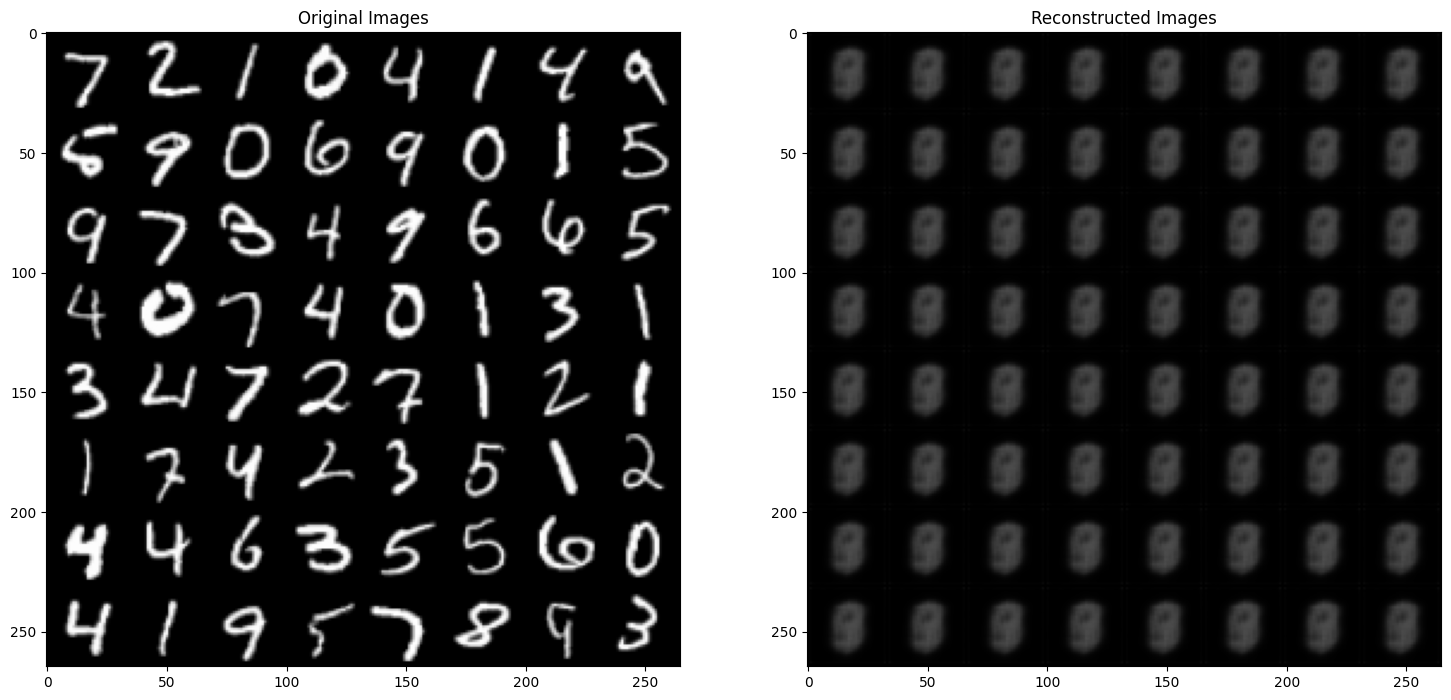

Reconstruction Error on test set: 0.0681568861339882


In [ ]:
from torchvision.utils import make_grid
import matplotlib.pyplot as plt

# Load trained VAE
vae = VAE(32)
vae.eval() # Evaluation mode for the model
vae.load_state_dict(torch.load(results_path+'/vae_mnist.ckpt')) # Load model
vae = vae.to(device)

# Visualize reconstructions on test samples

test_images,_ = next(iter(test_loader))
test_images = test_images.to(device)
# Get reconstructed test images with the VAE
_, z_mean, _ = vae(test_images)
x_rec = vae.decoder(z_mean)

plt.figure(figsize=(18,9))
image_grid = make_grid(test_images.cpu(),nrow=8,padding=1)
plt.subplot(1,2,1)
plt.imshow(image_grid.permute(1,2,0).detach().numpy())
plt.title('Original Images')

plt.subplot(1,2,2)
plt.title('Reconstructed Images')
image_grid = make_grid(x_rec.cpu(),nrow=8,padding=1)
plt.imshow(image_grid.permute(1,2,0).detach().numpy())
plt.show()

# Compute reconstruction loss on testing dataset
rec_loss_avg = 0
criterion = nn.MSELoss()
n_batches = 0
for i, (images, labels) in enumerate(test_loader):
  # Get batch of samples and labels
  images = images.to(device)

  # Forward pass
  z_mean, z_log_var = vae.encode(images)
  x_rec = vae.decoder(z_mean)
  reconstruction_loss = criterion(x_rec, images)
  rec_loss_avg += reconstruction_loss.cpu().item()
  n_batches += 1
print('Reconstruction Error on test set: ' + str(rec_loss_avg / n_batches))

### Visualize Randomly Generated Images

Now we will sample random vectors $\mathbf{z} \sim N(0,I)$ and create sythetic images with our trained decoder. Note that the generated images are not reconstructed from real images and, thus, they do not belong to the training set.

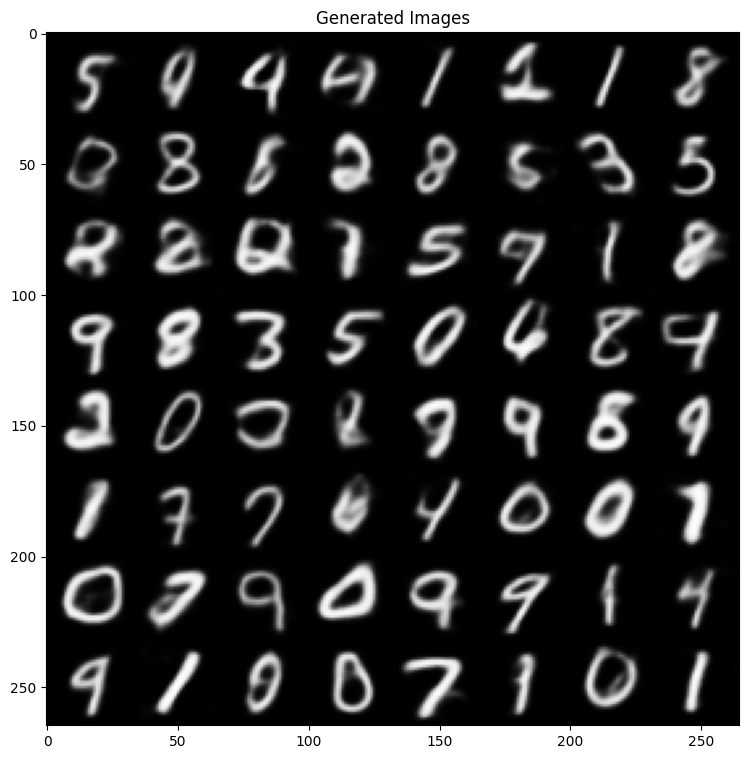

In [ ]:
### Generate random samples
n_samples = 64
vae.eval()
# Random vectors z~N(0,I)
z = torch.randn((n_samples,vae.out_features)).to(device)

# Genearte images with the decoder from the random vectors
x_rec = vae.decoder(z)

# Show synthetic images
plt.figure(figsize=(9,9))
plt.title('Generated Images')
image_grid = make_grid(x_rec.cpu(),nrow=8,padding=1)
plt.imshow(image_grid.permute(1,2,0).detach().numpy())

### Interpolation in the latent space

Another way to visualize VAE results is to perform interpolations in the latent space of vectors $\mathbf{z}$. In particular, we will generate different two different random vectors $\mathbf{z}_{init}$ and $\mathbf{z}_{final}$ and generate multiple images decoding the interpolations between them.

In [ ]:
import imageio
import numpy as np
from IPython.display import Image

### Generate random samples
vae.eval()
# 64 interpolations
n_samples = 64
n_iterpolations =50

# Sample a set of pairs z_init and z_final
z_init = torch.randn((n_samples,vae.out_features)).to(device)*2
z_final = torch.randn((n_samples,vae.out_features)).to(device)*2

# Compute interpolations between z_init and z_final
# and generate an image for each interpolation.
interpolation_images = []
for interp in range(0,n_iterpolations):
  interp_0_1 = float(interp) / (n_iterpolations-1)
  z = z_init*interp_0_1 + z_final*(1-interp_0_1)
  x_rec = vae.decoder(z)
  image_grid = make_grid(x_rec.cpu(),nrow=8,padding=1)
  image_grid = image_grid.permute(1,2,0).detach().numpy()
  # save the generated images in a list
  interpolation_images.append((image_grid*255.0).astype(np.uint8))

# Concatenate the inversion of the list to generate a "loop" animation
interpolation_images += interpolation_images[::-1]

# Generate and visualize a give showing the interpolation results.
imname = results_path+'/vae_interpolation_mnist.gif'
imageio.mimsave(imname, interpolation_images, fps=25)

with open(imname,'rb') as f:
    display(Image(data=f.read(), format='png',width=512,height=512))

Output hidden; open in https://colab.research.google.com to view.

## Example of Generative Adversarial Networks on MNIST

In the following we will implement, train and evaluate a GAN in MNIST dataset.


### GAN Definition

(1) The generator network will have the same definition than our VAE decoder
(2) The discriminator will have a similar definition than our VAE encoder. The difference is that the last fully-connected layer will be a binary classifier which will output a single value representing the probability of fake/real image.

In [ ]:
# Discriminator similar to VAE encoder
class Discriminator(nn.Module):
  def __init__(self, base_channels=16):
    super(Discriminator, self).__init__()
    # last fully connected layer acts as a a binary classifier
    self.classifier = Encoder(1,base_channels)

  # Forward pass obtaining the discriminator probability
  def forward(self,x):
    out = self.classifier(x)
    # use sigmoid to get the real/fake image probability
    return torch.sigmoid(out)

# Generator is defined as VAE decoder
class Generator(nn.Module):
  def __init__(self,in_features,base_channels=16):
    super(Generator, self).__init__()
    self.base_channels = base_channels
    self.in_features = in_features
    self.decoder = Decoder(in_features,base_channels)

  # Generate an image from vector z
  def forward(self,z):
    return torch.sigmoid(self.decoder(z))

  # Sample a set of images from random vectors z
  def sample(self,n_samples=256,device='cpu'):
    samples_unit_normal = torch.randn((n_samples,self.in_features)).to(device)
    return self.decoder(samples_unit_normal)

### GAN Train Function

Definition of the training process for our GAN. Generator and discriminator losses are jointly optimized.

In [ ]:
# GAN Train function. We have a generator and discriminator models and their respective optimizers.
def train_GAN(gen, disc,  train_loader, optimizer_gen, optim_disc,
              num_epochs=10, model_name='gan_mnist.ckpt', device='cpu'):
    gen = gen.to(device)
    gen.train() # Set the generator in train mode
    disc = disc.to(device)
    disc.train() # Set the discriminator in train mode

    total_step = len(train_loader)
    losses_list = []

    # Iterate over epochs
    for epoch in range(num_epochs):
        # Iterate the dataset
        disc_loss_avg = 0
        gen_loss_avg = 0
        nBatches = 0
        update_generator = True

        for i, (real_images, labels) in enumerate(train_loader):
            # Get batch of samples and labels
            real_images = real_images.to(device)
            n_images = real_images.shape[0]

            # Forward pass
            # Generate random images with the generator
            fake_images = gen.sample(n_images,device=device)

            # Use the discriminator to obtain the probabilties for real and generate imee
            prob_real = disc(real_images)
            prob_fake = disc(fake_images)

            # Generator loss
            gen_loss = -torch.log(prob_fake).mean()
            # Discriminator loss
            disc_loss = -0.5*(torch.log(prob_real) + torch.log(1-prob_fake)).mean()


            # We are going to update the discriminator and generator parameters alternatively at each iteration
            if(update_generator):
              # Optimize generator
              # Backward and optimize
              optimizer_gen.zero_grad()
              gen_loss.backward() # Necessary to not erase intermediate variables needed for computing disc_loss gradient
              optimizer_gen.step()
              update_generator = False
            else:
              # Optimize discriminator
              # Backward and optimize
              optimizer_disc.zero_grad()
              disc_loss.backward()
              optimizer_disc.step()
              update_generator = True


            disc_loss_avg += disc_loss.cpu().item()
            gen_loss_avg += gen_loss.cpu().item()

            nBatches+=1
            if (i+1) % 200 == 0:
                print ('Epoch [{}/{}], Step [{}/{}], Gen. Loss: {:.4f}, Disc Loss: {:.4f}'
                       .format(epoch+1, num_epochs, i+1, total_step, gen_loss_avg / nBatches, disc_loss_avg / nBatches))
        print ('Epoch [{}/{}], Step [{}/{}], Gen. Loss: {:.4f}, Disc Loss: {:.4f}'
                       .format(epoch+1, num_epochs, i+1, total_step, gen_loss_avg / nBatches, disc_loss_avg / nBatches))
        # Save model
        losses_list.append(disc_loss_avg / nBatches)
        torch.save(gan_gen.state_dict(), results_path+ '/' + model_name)

    return losses_list

### Trainning a GAN

In [ ]:
# Define Geneartor and Discriminator networks
gan_gen = Generator(32)
gan_disc = Discriminator()

#Initialize indepdent optimizer for both networks
learning_rate = .0005
optimizer_gen = torch.optim.Adam(gan_gen.parameters(),lr = learning_rate, weight_decay=1e-5)
optimizer_disc = torch.optim.Adam(gan_disc.parameters(),lr = learning_rate, weight_decay=1e-5)

# Train the GAN
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
loss_list = train_GAN(gan_gen,gan_disc, train_loader, optimizer_gen, optimizer_disc,
                      num_epochs=20, model_name='gan_mnist.ckpt', device=device)

### Visualize synthetic images

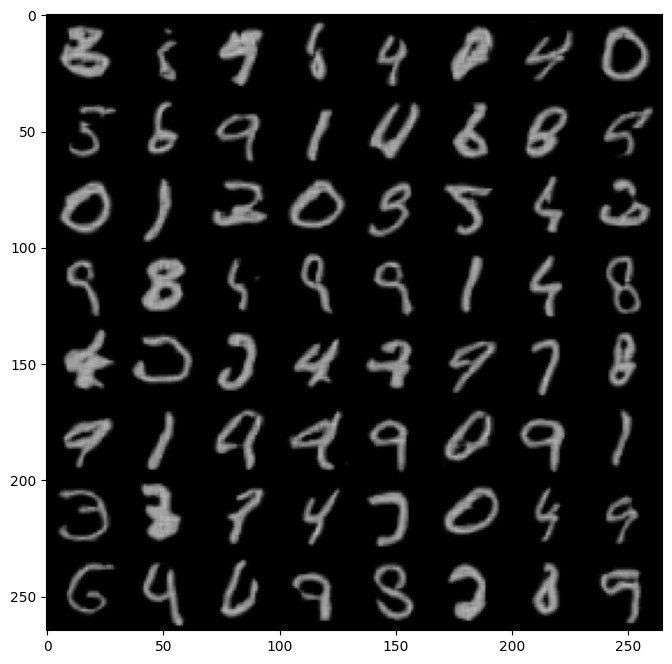

In [ ]:
# Load generator
gan_gen = Generator(32)
gan_gen.load_state_dict(torch.load(results_path+'/gan_mnist.ckpt'))
gan_gen.eval() # Put in eval model
gan_gen = gan_gen.to(device)

# Generate random images from sampled vectors z and visualize them
x_gen = gan_gen.sample(64,device=device)
image_grid = make_grid(x_gen.cpu(),nrow=8,padding=1)
plt.figure(figsize=(8,8))
plt.imshow(image_grid.permute(1,2,0).detach().numpy())


### Visualize latent space interpolations

Similar to VAEs we can also visualize images generated from z interpolations in GANs

In [ ]:
import imageio
import numpy as np
from IPython.display import Image

### Generate random samples
gan_gen = Generator(32)
gan_gen.load_state_dict(torch.load(results_path+'/gan_mnist.ckpt'))
gan_gen = gan_gen.to(device)
gan_gen.eval()


n_samples = 64
n_iterpolations =50

z_init = torch.randn((n_samples,vae.out_features)).to(device)
z_final = torch.randn((n_samples,vae.out_features)).to(device)

interpolation_images = []
for interp in range(0,n_iterpolations):
  interp_0_1 = float(interp) / (n_iterpolations-1)
  z = z_init*interp_0_1 + z_final*(1-interp_0_1)
  x_rec = gan_gen.decoder(z.to(device))
  image_grid = make_grid(x_rec.cpu(),nrow=8,padding=1)
  image_grid = image_grid.permute(1,2,0).detach().numpy()

  interpolation_images.append((image_grid*255.0).astype(np.uint8))
interpolation_images += interpolation_images[::-1]

imname = results_path+'/gan_interpolation_mnist.gif'
imageio.mimsave(imname, interpolation_images, fps=25)

with open(imname,'rb') as f:
    display(Image(data=f.read(), format='png',width=512,height=512))

Output hidden; open in https://colab.research.google.com to view.